In [1]:
import cv2
import numpy as np
import os

from visualization_utils import visualize
from PIL.Image import fromarray
from pose_models import PoseEstimator
from evo_models import Evoskeleton

### Define some helper functions
Function `compute_angle_between_two_bones` tells of itself. <br />

In [2]:
def compute_angle_between_two_bones(bone1, bone2, joint_point):
    
    """
    Compute angle in limbs conjunctions. Like knees of elbows
    Args:
        bone1: start point of bone. For instance origin of  left hip bone.
        bone2: end point of bone. Like, point where shinebone connects knee and ankle
        joint_point: point of two bones concunction. Like, knee.
    """
    
    # For proper computation of two vectors we assume that their origin
    # located at "zero" coordinates along all axes.
    # So we simply deduct from bones coordinates their 'conjuction' coordinates.
    bone1 = bone1.copy() - joint_point
    bone2 = bone2.copy() - joint_point
    
    # Next step is to find out magnitude of every vector.
    # And 'squash' them to 'unit' vectors with length = 1.
    # We need them in order to compute cosine similarity btwn 2 vectors.
    unit_v1 = bone1 / np.linalg.norm(bone1)
    unit_v2 = bone2 / np.linalg.norm(bone2)
    
    # Compute cosine similarity, angle in radians, and convert to degrees.
    cosine_sim = np.dot(unit_v1, unit_v2)
    angle = np.arccos(cosine_sim)
    angle_degrees = angle * 180 / np.pi
    return angle_degrees


#### Initialize pose predictors
First 2D pose estimator neural net ingests image and predicts 2D skeleton. <br />
Afterwards 3D estimator neural net ingests 2D skeleton and predicts 3D skeleton

In [3]:
pose_estimator_2d = PoseEstimator()
pose_estimator_3d = Evoskeleton(model_path='weights/model_3d.th')

#### Run Angles predictions
It is extremely IMPORTANT:
1. only one human body should be presented on the image
2. Body should in the center of the image
3. Image should be cropped nearly by boundaries of body

input_image.jpeg  3D angles
KNEES  left: 77.33 | right: 91.58 degrees.
ELBOWS left: 67.83 | right: 80.77 degrees


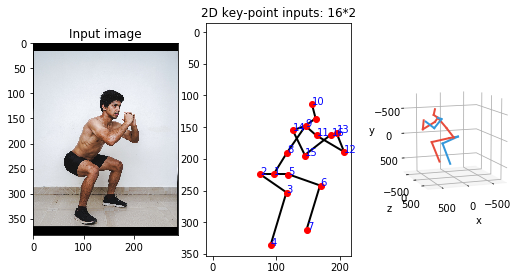

runner.jpeg  3D angles
KNEES  left: 85.96 | right: 155.78 degrees.
ELBOWS left: 90.66 | right: 116.61 degrees


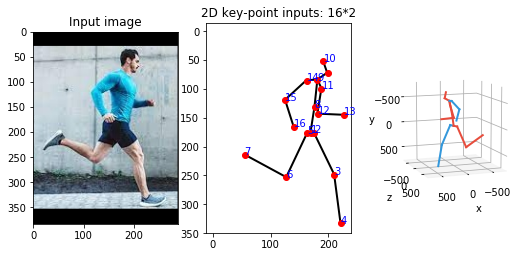

In [16]:
img_dir = 'images'
img_list = [x for x in os.listdir(img_dir) if x.split('.')[-1] in ['jpeg', 'jpg', 'png']]
for image_name in img_list:
    img_path = os.path.join(img_dir, image_name)
    image_orig = cv2.imread(img_path)

    skeleton_2d, img = pose_estimator_2d(image_orig)
    skeleton_3d = pose_estimator_3d(skeleton_2d)
    
    # These vars are for clarity, could eliminate this redundancy on production stage.
    RIGHT_HIP, RIGHT_KNEE, RIGHT_ANKLE  = skeleton_3d[1:4]
    LEFT_HIP, LEFT_KNEE, LEFT_ANKLE = skeleton_3d[6:9]
    LEFT_SHOULDER, LEFT_ELBOW, LEFT_WHIRST = skeleton_3d[17:20]
    RIGHT_SHOULDER, RIGHT_ELBOW, RIGHT_WHIRST = skeleton_3d[25:28]
    SPINE_BOTTOM = skeleton_3d[0]
    SPINE_UP = skeleton_3d[12]

    # Compute angles.
    angle_left_knee = compute_angle_between_two_bones(LEFT_HIP, LEFT_ANKLE, LEFT_KNEE)
    angle_right_knee = compute_angle_between_two_bones(RIGHT_HIP, RIGHT_ANKLE, RIGHT_KNEE)
    angle_left_elbow = compute_angle_between_two_bones(LEFT_SHOULDER, LEFT_WHIRST, LEFT_ELBOW)
    angle_right_elbow = compute_angle_between_two_bones(RIGHT_SHOULDER, RIGHT_WHIRST, RIGHT_ELBOW)

    print(image_name, ' 3D angles')
    print('KNEES  left: %.2f | right: %.2f degrees.' % (angle_left_knee, angle_right_knee))
    print('ELBOWS left: %.2f | right: %.2f degrees' % (angle_left_elbow, angle_right_elbow))

    # Matplotlib plotting tool for visualisation.
    visualize(img, skeleton_2d, skeleton_3d)